# A Democratic World Wide Web
## An Introduction and Implementation of the Plebeian Algorithm to Freely Combat Misinformation
## By: Benjamin D. Fedoruk

### About the Speaker
Benjamin D. Fedoruk is a data scientist, currently studying mathematics and computer science at Ontario Tech University. He has completed various data science works, including research into carbon pricing efficacy, public transit systems in northern/rural communities, and most majorly, has conducted research to reduce the spread of misinformation on social media. He is interested in NLP, and data science at-large. 

### Workshop Overview
The Internet is filled with a vast array of information -- some is true, some is false. But, is there a programmatic method to effectively determine the verity of information, without the need for human intervention? This is where the Plebeian Algorithm shines, which you will learn about in this workshop. You will learn how to implement a Plebeian-esque algorithm into your personal projects. 

### Intended Audience
This workshop is for you if:

- you have an introductory level of data science skills in Python.
- you are interested in natural language processing.
- you want to learn applications of data science skills to real-world problems.
- you want to find solutions to the spread of misinformation. 
- you are intrigued by problem solving approaches using data science. 

### Topics Covered
Topics covered in this workshop include:

- Plebeian algorithms
- democratic moderation of content
- natural language processing, applied to a real-world issue
- expansion on the basics of Python data science. 

### Workshop Takeaways
Topics covered in this workshop include:

- Plebeian algorithms
- democratic moderation of content
- natural language processing, applied to a real-world issue
- expansion on the basics of Python data science. 

## Pre-Requisites

I am going to be using Jupyter Notebook for this course, but you can feel free to follow along in any other Python setup. 

If you haven't installed some of the core Python packages (using `pip`), here's what you'll need to run (on a Bash prompt). This can also be done using Anaconda, in a similar way. I'm assuming that if you're attending this workshop, you'll know how to install packages for your specific Python setup! 

In [111]:
%%capture
# Below is the command you should run in a prompt:
!pip install numpy matplotlib nltk pandas demoji seaborn urllib3 basc_py4chan bs4

Defaulting to user installation because normal site-packages is not writeable


## Imports
Below are the imports for all of the work we'll be doing on this file. 

In [114]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
import demoji
import re
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request
import warnings
import datetime
import json
import basc_py4chan
from bs4 import BeautifulSoup

And here are some of the basic declarations we'll need.

In [77]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
plt.rcParams['figure.figsize'] = [10, 5]

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ben/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Analyzing YouTube Comments from a Dataset
The first exploration we will do with the Plebeian Algorithm will be an analysis of YouTube comments from a dataset. The dataset should be contained in the same directory as this .ipynb file, saved as a CSV (comma-separated values) file. The file is named `youtube_comments_usa.csv`. 

Although it may be advisable to add a popularity check to the comments being analyzed, this approach will take all comments into account, as most posts have less than 5 likes or replies. 

**Warning**: The comments in this dataset are not curated, and are directly gathered from YouTube. As such, there is a strong chance that some comments may contain choice language, or potentially triggering material. I recommend that if this is a concern for you, that you avoid printing out the `comment_text` column of the dataset. 

### Import the Dataset
Below, we shall import the dataset using pandas. Some lines in the CSV are skipped -- although this is unfortunate, this workshop will not focus on the data cleaning of this retrieved data. Instead, we will simply skip those entries: we have enough data without them. They will be stored in a pandas dataframe, which can essentially be thought of as a table, with rows and columns. The columns have headers, which we will print in the subsequent section. 

In [56]:
df = pd.read_csv('youtube_comments_us.csv', error_bad_lines=False, engine='python')

/usr/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
Skipping line 24537: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead
Skipping line 41589: ',' expected after '"'
Skipping line 74586: ',' expected after '"'
Skipping line 114465: ',' expected after '"'
Skipping line 141800: ',' expected after '"'
Skipping line 142496: ',' expected after '"'
Skipping line 162506: ',' expected after '"'
Skipping line 189732: ',' expected after '"'
Skipping line 195584: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead
Skipping line 216199: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' 

### Preliminary Analysis of the Dataset
Here's some quick information about the dataset we're working with. I'll print off the first few comments, the columns, and the number of rows/comments. 

In [57]:
print(df.head())
print('\n\n')
print(f'{df.columns=}')
print('\n\n')
print(f'Number of Comments: {df.shape[0]}')

def remove_links_translate_emoji(text: str) -> str:
    return re.sub(r'\w:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', demoji.replace_with_desc(text, ' ').lower())

      video_id                                       comment_text likes  \
0  XpVt6Z1Gjjo                  Logan Paul it's yo big day ‼️‼️‼️     4   
1  XpVt6Z1Gjjo  I've been following you from the start of your...     3   
2  XpVt6Z1Gjjo                 Say hi to Kong and maverick for me     3   
3  XpVt6Z1Gjjo                                MY FAN . attendance     3   
4  XpVt6Z1Gjjo                                         trending 😉     3   

  replies  
0       0  
1       0  
2       0  
3       0  
4       0  



df.columns=Index(['video_id', 'comment_text', 'likes', 'replies'], dtype='object')



Number of Comments: 691375


### Data Cleaning and Sentiment Analysis
Let's do some quick cleaning and also generate some sentiment analysis for each comment. We are using VADER, as described above. VADER is the ideal sentiment analyzer for informal text with slang (see *Hands-On Python Natural Language Processing* by Kedia and Rasu). Obviously, YouTube comments contain this level of informal language.

In [63]:
all_texts = set(df['comment_text'].tolist()[:1000])
results = []

for line in all_texts:
    if not type(line) == str:
        continue
    if line == '' or line == np.nan or 'nan' in line:
        continue
    line = remove_links_translate_emoji(line)
    pol_score = sia.polarity_scores(line)
    if pol_score['compound'] == 0.0:
        continue
    pol_score['text'] = line
    results.append(pol_score)

df_nlp = pd.DataFrame.from_records(results)
df_nlp['label'] = 0
df_nlp.loc[df_nlp['compound'] > 0.1, 'label'] = 1
df_nlp.loc[df_nlp['compound'] < -0.1, 'label'] = -1

print(df_nlp.head())

     neg    neu    pos  compound  \
0  0.346  0.474  0.180   -0.3612   
1  0.059  0.912  0.029   -0.2821   
2  0.000  0.635  0.365    0.3182   
3  0.106  0.792  0.102   -0.0384   
4  0.466  0.534  0.000   -0.5413   

                                                text  label  
0  attack of titan squad were u at ghost  red hea...     -1  
1  dont be sorry pewds, everybody says something ...     -1  
2                         its just a word, calm down      1  
3  the phone itself looks pretty great but it isn...      0  
4                    so disappointing this movie was     -1  


### Visualize The Results
Great work so far! We will now use seaborn to visualize the results. 

[Text(0.5, 0, 'compounded positivity score on [-1,1]'),
 Text(0, 0.5, 'frequency'),
 Text(0.5, 1.0, 'YouTube Comments Frequency of Positivity from Dataset')]

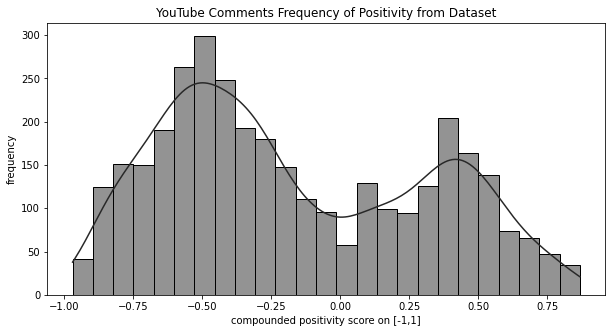

In [105]:
fig = sns.histplot(data=df_nlp, 
                   x='compound', 
                   bins=25, 
                   kde=True,
                   color='#282828')
fig.set(xlabel='compounded positivity score on [-1,1]',
        ylabel='frequency',
        title='YouTube Comments Frequency of Positivity from Dataset')
# If you're not on Jupyter Notebook, may want to use:
# plt.show()

## Analyzing Reddit using API
Now we'll do another case study, using Reddit. We will be using `urllib` and `pushshift` to grab posts on Reddit. This can include original posts and comments, however for this exercise (for the sake of time) I will be only gathering the headlines. Obviously this will be easier to code, but it should be noted that the results may not be useful in any meaningful sense. 

**Warning**: The text entries gathered in this exercise will be gathered live during the workshop. I cannot guarantee the profanity of the language used. It may be triggering to some individuals. I recommend that if this is a concern for you, that you avoid printing out the text entries gathered. 
### Pre-Requisites for URLLib
Below are some quick setup procedures we need to follow for `urllib`. To save time, I have provided these in the pre-notes. 

In [87]:
def load_results(lower_bound_timestamp, upper_bound_timestamp, target_result_size, target_subreddit, score_threshold):
    headline_collection = set()
    reddit_data_url = f'https://api.pushshift.io/reddit/submission/search/?after={lower_bound_timestamp}&before={upper_bound_timestamp}&sort_type=score&sort=desc&subreddit={target_subreddit}&size={target_result_size}&score={score_threshold}'
    
    try:
        with urllib.request.urlopen(reddit_data_url) as url:
            data = json.loads(url.read().decode())
            for submission in data['data']:
                headline_collection.add(submission['title'])
        return headline_collection
    except urllib.error.HTTPError as e:
        return set()
    except urllib.error.URLError as e:
        return set()
    
headlines = set()
time_now = datetime.datetime.now()
limit_delta = 365
limit_lower_delta = 360
subreddit = "politics"
result_size = 1000
score_limit = ">1"

### Scrape from Reddit
We'll now scrape from Reddit using the method we created above. This step may take some time to execute.

In [102]:
# This takes some time. 
for i in range(0,10):
    previous_timestamp = int((time_now - datetime.timedelta(days=limit_delta)).timestamp())
    current_timestamp = int((time_now - datetime.timedelta(days=limit_lower_delta)).timestamp())
    full_collection = load_results(previous_timestamp, current_timestamp, result_size, subreddit, score_limit)
    headlines = headlines.union(full_collection)
    limit_delta = limit_delta - 5
    limit_lower_delta = limit_lower_delta - 5

### Get Sentiment Analysis Results
You know the drill -- time to do some sentiment analysis using nltk and VADER.

In [103]:
results = []
for line in headlines:
    pol_score = sia.polarity_scores(line)
    if pol_score['compound'] == 0.0:
        continue
    pol_score['headline'] = line
    results.append(pol_score)

df_nlp = pd.DataFrame.from_records(results)
df_nlp['label'] = 0
df_nlp.loc[df_nlp['compound'] > 0.1, 'label'] = 1
df_nlp.loc[df_nlp['compound'] < -0.1, 'label'] = -1

print(df_nlp.head())

     neg    neu    pos  compound  \
0  0.565  0.435  0.000   -0.8316   
1  0.199  0.622  0.178   -0.3612   
2  0.167  0.833  0.000   -0.3818   
3  0.318  0.596  0.086   -0.5423   
4  0.000  0.816  0.184    0.4019   

                                            headline  label  
0        Budowsky: Mad as hell at Manchin and Sinema     -1  
1  155 Years After Abolition, Slavery Is Still Le...     -1  
2  Missouri Republicans fight ‘will of the people...     -1  
3  Watch Chris Wallace Challenge Sen. Blunt: Have...     -1  
4  'You Were One of Trump's Yes Men,' Fox's Chris...      1  


### Visualize the Results
Well, that was a little bit more tough than last time, but hopefully it feels a little bit familiar. Hopefully at this point, you're beginning to understand the idea we're going for. 

[Text(0.5, 0, 'compounded positivity score on [-1,1]'),
 Text(0, 0.5, 'frequency'),
 Text(0.5, 1.0, 'Reddit r/politics Frequency of Positivity from API')]

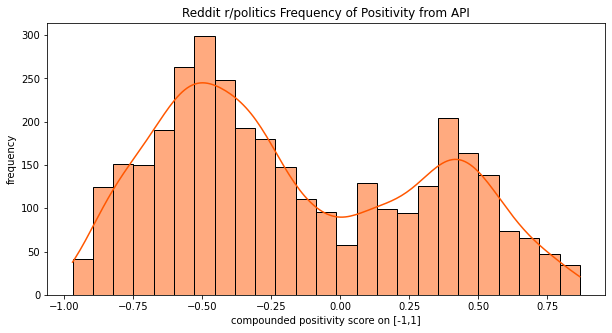

In [106]:
fig = sns.histplot(data=df_nlp, 
                   x='compound', 
                   bins=25, 
                   kde=True,
                   color='#ff5700')
fig.set(xlabel='compounded positivity score on [-1,1]',
        ylabel='frequency',
        title='Reddit r/politics Frequency of Positivity from API')
# If you're not on Jupyter Notebook, may want to use:
# plt.show()

## Analyzing 4chan using API
Let's do one final analysis using 4chan. We will be using `basc_py4chan` to grab posts on 4chan. The 4chan platform offers users visibility of only the top posts -- once a post is no longer in the top set of posts, it is removed. Thus, 4chan offers users ephemerality, and also anonymity. 

**Warning**: The text entries gathered in this exercise will be gathered live during the workshop. I cannot guarantee the profanity of the language used. It may be triggering to some individuals. I recommend that if this is a concern for you, that you avoid printing out the text entries gathered. I know I've been saying this for the past few, but this is the one time I'm going to nearly guarantee that you'll see some potentially disturbing material. As mentioned, this is due to the ephemerality and anonymity of 4chan. I'll avoid printing them out. 
### Pre-Requisites for URLLib
Below are some quick setup procedures we need to follow for `urllib`. To save time, I have provided these in the pre-notes.

In [113]:
def clean_comment(comment: str) -> str:
    c = re.sub('https://\S+|https://\S+', '', comment)
    return BeautifulSoup(c, 'lxml').text

warnings.filterwarnings('ignore')

### Scrape /b/ from 4chan
We are going to be scraping the /b/ board from 4chan. 

In [115]:
board = basc_py4chan.Board('b')
all_thread_ids = board.get_all_thread_ids()

titles = []
comments = []

for thread_id in all_thread_ids:
    thread = board.get_thread(thread_id)
    try:
        title = thread.topic.comment
        
        for post in thread.posts:
            comments.append(clean_comment(post.comment))
            titles.append(title)
    except:
        continue

texts = titles + comments

/usr/lib/python3.9/site-packages/bs4/__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/usr/lib/python3.9/site-packages/bs4/__init__.py:332: MarkupResemblesLocatorWarning: ".." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


### Perform Sentiment Analysis on Results
You guessed it! Time to do the same process again! Let's use nltk and VADER to analyze the sentiment of these posts. 

In [119]:
results = []
for line in set(texts):
    pol_score = sia.polarity_scores(line)
    if pol_score['compound'] == 0.0:
        continue
    pol_score['headline'] = line
    results.append(pol_score)

df_nlp = pd.DataFrame.from_records(results)
df_nlp['label'] = 0
df_nlp.loc[df_nlp['compound'] > 0.1, 'label'] = 1
df_nlp.loc[df_nlp['compound'] < -0.1, 'label'] = -1

# I have commented this out due to potential vulgarity. I will print the other lines
# print(df_nlp.head())
print(df_nlp[["neg", "neu", "pos", "compound", "label"]].head())

     neg    neu    pos  compound  label
0  0.161  0.839  0.000   -0.3182     -1
1  0.000  0.571  0.429    0.4588      1
2  0.124  0.699  0.177    0.2500      1
3  0.146  0.854  0.000   -0.5574     -1
4  0.199  0.683  0.118   -0.5355     -1


### Visualize the Results
Time to see what this means, again! Let's plot these results! 

[Text(0.5, 0, 'compounded positivity score on [-1,1]'),
 Text(0, 0.5, 'frequency'),
 Text(0.5, 1.0, '4chan /b/ Frequency of Positivity from API')]

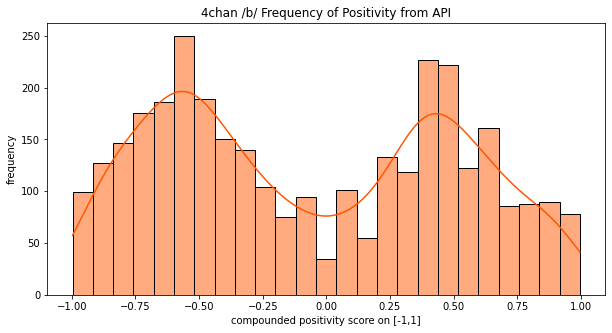

In [120]:
fig = sns.histplot(data=df_nlp, 
                   x='compound', 
                   bins=25, 
                   kde=True,
                   color='#ff5700')
fig.set(xlabel='compounded positivity score on [-1,1]',
        ylabel='frequency',
        title='4chan /b/ Frequency of Positivity from API')
# If you're not on Jupyter Notebook, may want to use:
# plt.show()